In [6]:
# %matplotlib widget
import numpy as np 
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt
import os
import sys
import importlib

sys.path.append('/Users/zacharykelly/Documents/MATLAB/projects/combiExperiments/code/lightLogger/camera')
import Camera_util

In [7]:
# Define macro information about where to find the directories/files for all of the data
path_to_ssd: str = '/Volumes/EXTERNAL1'         
experiment_name: str = '100buffFrameCaptureTime_5hz_0NDF'
frequency: float = 5
NDF: int = 0 

In [12]:
def generate_temporal_support(signal: np.ndarray, CAM_FPS: float= Camera_util.CAM_FPS) -> np.ndarray:
    t: np.ndarray = np.arange(0, signal.shape[0]/CAM_FPS, 1/CAM_FPS)

    return t

In [8]:
# Define paths to individual sensor readings
world_cam_dir: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_world')
pupil_cam_dir: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_pupil')
sunglasses_file: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_sunglasses.txt')
MS_readings_dir: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_MS_readings')
frame_capture_time_file: str = os.path.join(path_to_ssd, experiment_name, f'{experiment_name}_world_frameTimings.csv')

assert(all(os.path.exists(path) == True for path in [world_cam_dir, pupil_cam_dir, MS_readings_dir, sunglasses_file]))

In [13]:
frame_timings_df = Camera_util.parse_frame_capture_file(frame_capture_time_file)

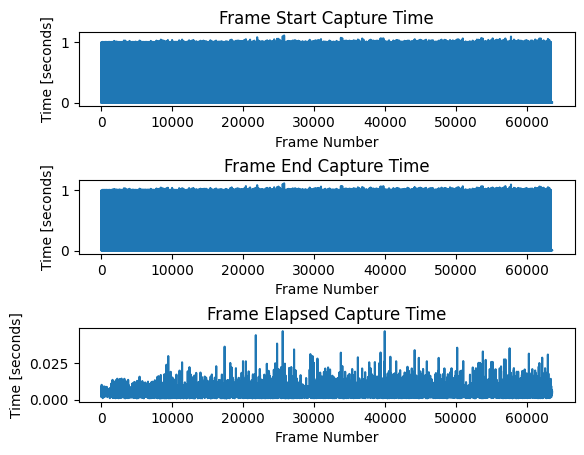

In [10]:
fig, axes = plt.subplots(3,1)

# First, plot the difference between the start capture times
axes[0].set_title('Frame Start Capture Time')
axes[0].set_xlabel('Frame Number')
axes[0].set_ylabel('Time [seconds]')
axes[0].plot(np.abs(np.diff(frame_timings_df['Begin'])))

# Then, plot the difference between the end capture times 
axes[1].set_title('Frame End Capture Time')
axes[1].set_xlabel('Frame Number')
axes[1].set_ylabel('Time [seconds]')
axes[1].plot(np.abs(np.diff(frame_timings_df['End'])))

# Then, plot the differences betweeen the start and end 
axes[2].set_title('Frame Elapsed Capture Time')
axes[2].set_xlabel('Frame Number')
axes[2].set_ylabel('Time [seconds]')
axes[2].plot(frame_timings_df['End'] - frame_timings_df['Begin'])

plt.subplots_adjust(hspace=1)

plt.show()

(105.0, 106.0)

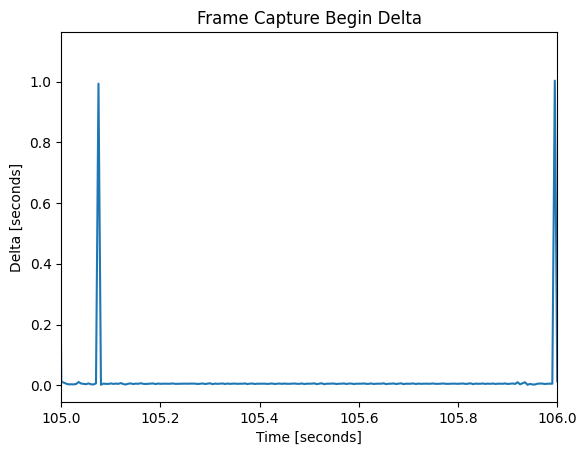

In [19]:
signal = np.abs(np.diff(frame_timings_df['Begin']))
t = generate_temporal_support(signal, 200)

plt.title('Frame Capture Begin Delta')
plt.xlabel('Time [seconds]')
plt.ylabel('Delta [seconds]')
plt.plot(t, signal)

plt.xlim(104.95,106)


(105.0, 106.0)

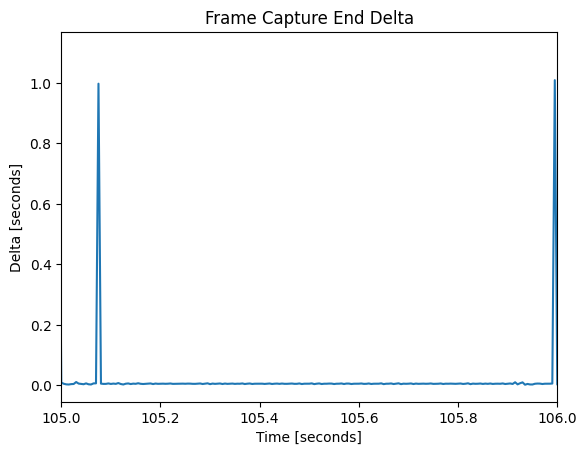

In [20]:
signal = np.abs(np.diff(frame_timings_df['End']))
t = generate_temporal_support(signal, 200)

plt.title('Frame Capture End Delta')
plt.xlabel('Time [seconds]')
plt.ylabel('Delta [seconds]')
plt.plot(t, signal)

plt.xlim(104.95,106)

(105.0, 106.0)

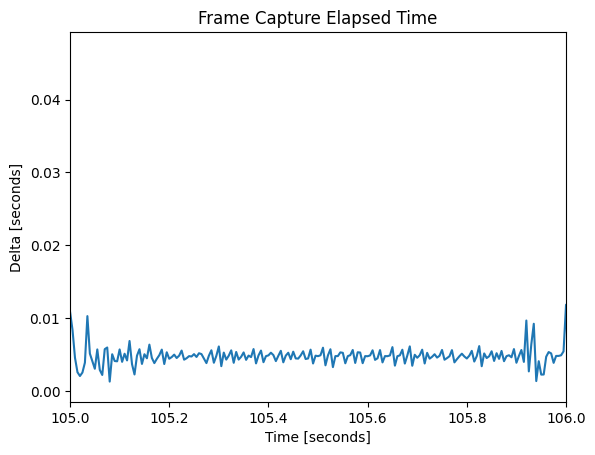

In [21]:
signal = np.abs(frame_timings_df['End'] - frame_timings_df['Begin'])
t = generate_temporal_support(signal, 200)

plt.title('Frame Capture Elapsed Time')
plt.xlabel('Time [seconds]')
plt.ylabel('Delta [seconds]')
plt.plot(t, signal)

plt.xlim(104.95,106)

In [ ]:
from collections import Counter 

val_freq = Counter(np.abs(np.diff(frame_timings_df['Begin'])))

for (key, val) in val_freq.most_common():
    print(f'Val: {key} | Freq: {val} \n')

In [ ]:
print(len(chunks))

chunk_0, chunk_1 = Camera_util.parse_mean_frame_array_buffer(chunks[0]), Camera_util.parse_mean_frame_array_buffer(chunks[1])



In [ ]:
Camera_util.plot_fit(fits[0], 199.8157786771373, start_second=58, end_second=60)


In [ ]:
# Examine the world cam data 
sys.path.append('/Users/zacharykelly/Documents/MATLAB/projects/combiExperiments/code/lightLogger/camera') # append the path to the camera libraries so we can use their files
import recorder     
import Camera_util

importlib.reload(Camera_util)

# Define the chunksize of time to analyze at a given time 
chunk_seconds: int = 60 # Look at one minute chunks

# Load in the paths20 to the 1-second buffer files 
buffer_files: list = [os.path.join(world_cam_dir, file) 
                     for file in natsorted(os.listdir(world_cam_dir))]

# Define the chunks
chunks: list = [buffer_files[i:i+chunk_seconds] 
               for i in range(0, len(buffer_files), chunk_seconds)]

# Initialize a container for the fit info for each chunk 
r2_values: list = []
amplitudes: list = []
phases: list = []
fpss: list = []

# Retrieve a list of the fi%matplotlib widgetts of the observed modulations
fits: list = []

# Iterate over the chunks
for chunk_idx, chunk in enumerate(chunks):
    print(f'Analyzing chunk {chunk_idx+1}/{len(chunks)} with size: {len(chunk)} buffers/seconds...')

    # Load in the frames from this chunk
    chunk_frames: np.ndarray = Camera_util.parse_mean_frame_array_buffer(chunk)

    # Initialize an axis to display the fit on 
    fig, ax = plt.subplots(1,1)

    # Fit the modulation for this chunk (without plotting)
    #print(f'Estimating fit with: {recorder.CAM_FPS}FPS')
    ret_info: tuple = Camera_util.fit_source_modulation(chunk_frames, str(NDF), frequency, ax=ax, fps_guess=200.2, fps_guess_increment=(0,0))

    # Retrieve the amplitude and phase for the fit 
    amplitude, phase, observed_fps = ret_info[:3]

    # Retrieve the R2 from the ret information
    r2: float = ret_info[-1][-1] 

    # Append the info to the running lists of info 
    r2_values.append(r2)
    amplitudes.append(amplitude)
    phases.append(phase)
    fits.append(ret_info[-1][:-1])
    fpss.append(observed_fps)

    # Show the fit
    plt.show()

    # Close the figure
    plt.close(fig)



In [ ]:
# Plot the R2, amplitudes, and phase by buffer 
# in both log and non-log scale
fig, axes = plt.subplots(4,2, figsize=(16,10))

# Keep track of what axis we are on 
ax_num: int = 0 

# Iterate over the measurements with their associated axes and plot them
for i, (measurement, name, ax_row) in enumerate(zip((r2_values, amplitudes, phases, fpss), ('R2', 'Amplitude', 'Phase', 'FPS'), axes)):
    # Retrieve the base 10 ax to plot on 
    # and the log ax 
    ax: plt.Axes = ax_row[0]
    log_ax: axes = ax_row[1]

    # Title the graphs
    ax.set_title(name)
    log_ax.set_title(f'{name} LOG')

    # Label the X axes 
    ax.set_xlabel('Chunk Number')
    log_ax.set_xlabel('Chunk Number')


    # Label the Y axes
    ax.set_ylabel('Value')
    log_ax.set_ylabel('Value [LOG]')

    # Plot the data 
    ax.plot(measurement)
    log_ax.plot(np.log10(measurement))


    # Update the ax num
    ax_num += 2 
    
# Adjust the spacing in the plot
plt.subplots_adjust(wspace=0.5, hspace=1)

# Show the plot
plt.show()

In [ ]:
avg_r2_100, median_r2_100 = np.mean(r2_values), np.median(r2_values)

print(avg_r2_100)
print(median_r2_100)

In [ ]:
avg_r2_30, median_r2_30 = np.mean(r2_values), np.median(r2_values)

print(avg_r2_30)
print(median_r2_30)